In [8]:
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR


warnings.filterwarnings("ignore")

In [9]:
# Please look at relationships between A_1 and A_2 as well as A_1 and A_3. Please do this for date range between 1st of Jan and 30th of Sep for a given calendar year. Are there any periods within this time frame when the relationships change significantly?
# Please look at relationship between A_4 and A_5 as well as A_4 and A_6.
# If there is anything at all that you can deduce from the data set, please highlight it. 

In [10]:
def get_data():
    df = pd.read_csv("Test Data Set.csv",index_col=0)
    df['Dates'] = pd.to_datetime(df['Dates'],dayfirst=True)
    df = df.dropna(how="any")
    df.set_index("Dates",inplace=True)

    return df
df = get_data()
display(df)
cols = ['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6']



# df.info()
# df.describe()

# diff = df[cols].diff()
# diff.plot(subplots=True,figsize=(12,8))
# plt.show()

,A_1,A_2,A_3,A_4,A_5,A_6
Dates,,,,,,
2021-01-01,-30.350131,-1.649292,49.740842,0.34,7.42,5.12
2021-01-05,-22.041486,0.343078,49.351151,0.72,7.51,5.28
2021-01-06,-18.551989,7.660540,48.987410,0.90,7.92,4.68
2021-01-08,-9.791329,-0.185945,48.775638,0.99,8.87,4.80
2021-01-11,-11.579214,4.902499,48.922681,0.89,8.35,5.19
...,...,...,...,...,...,...
2023-08-18,40.080057,5.965446,27.702392,12.54,24.84,37.63
2023-08-21,38.404592,1.417818,27.702392,12.54,23.17,36.47
2023-08-22,36.125267,-1.829972,27.702392,12.54,24.36,37.78


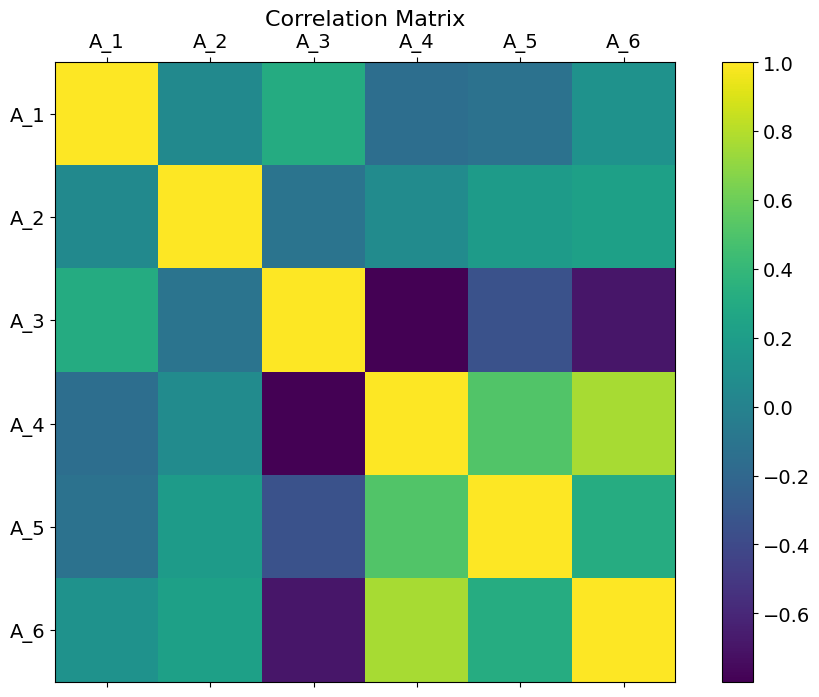

In [11]:
def corr_plot(df):
    f = plt.figure(figsize=(12,8))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16)

corr_plot(df)

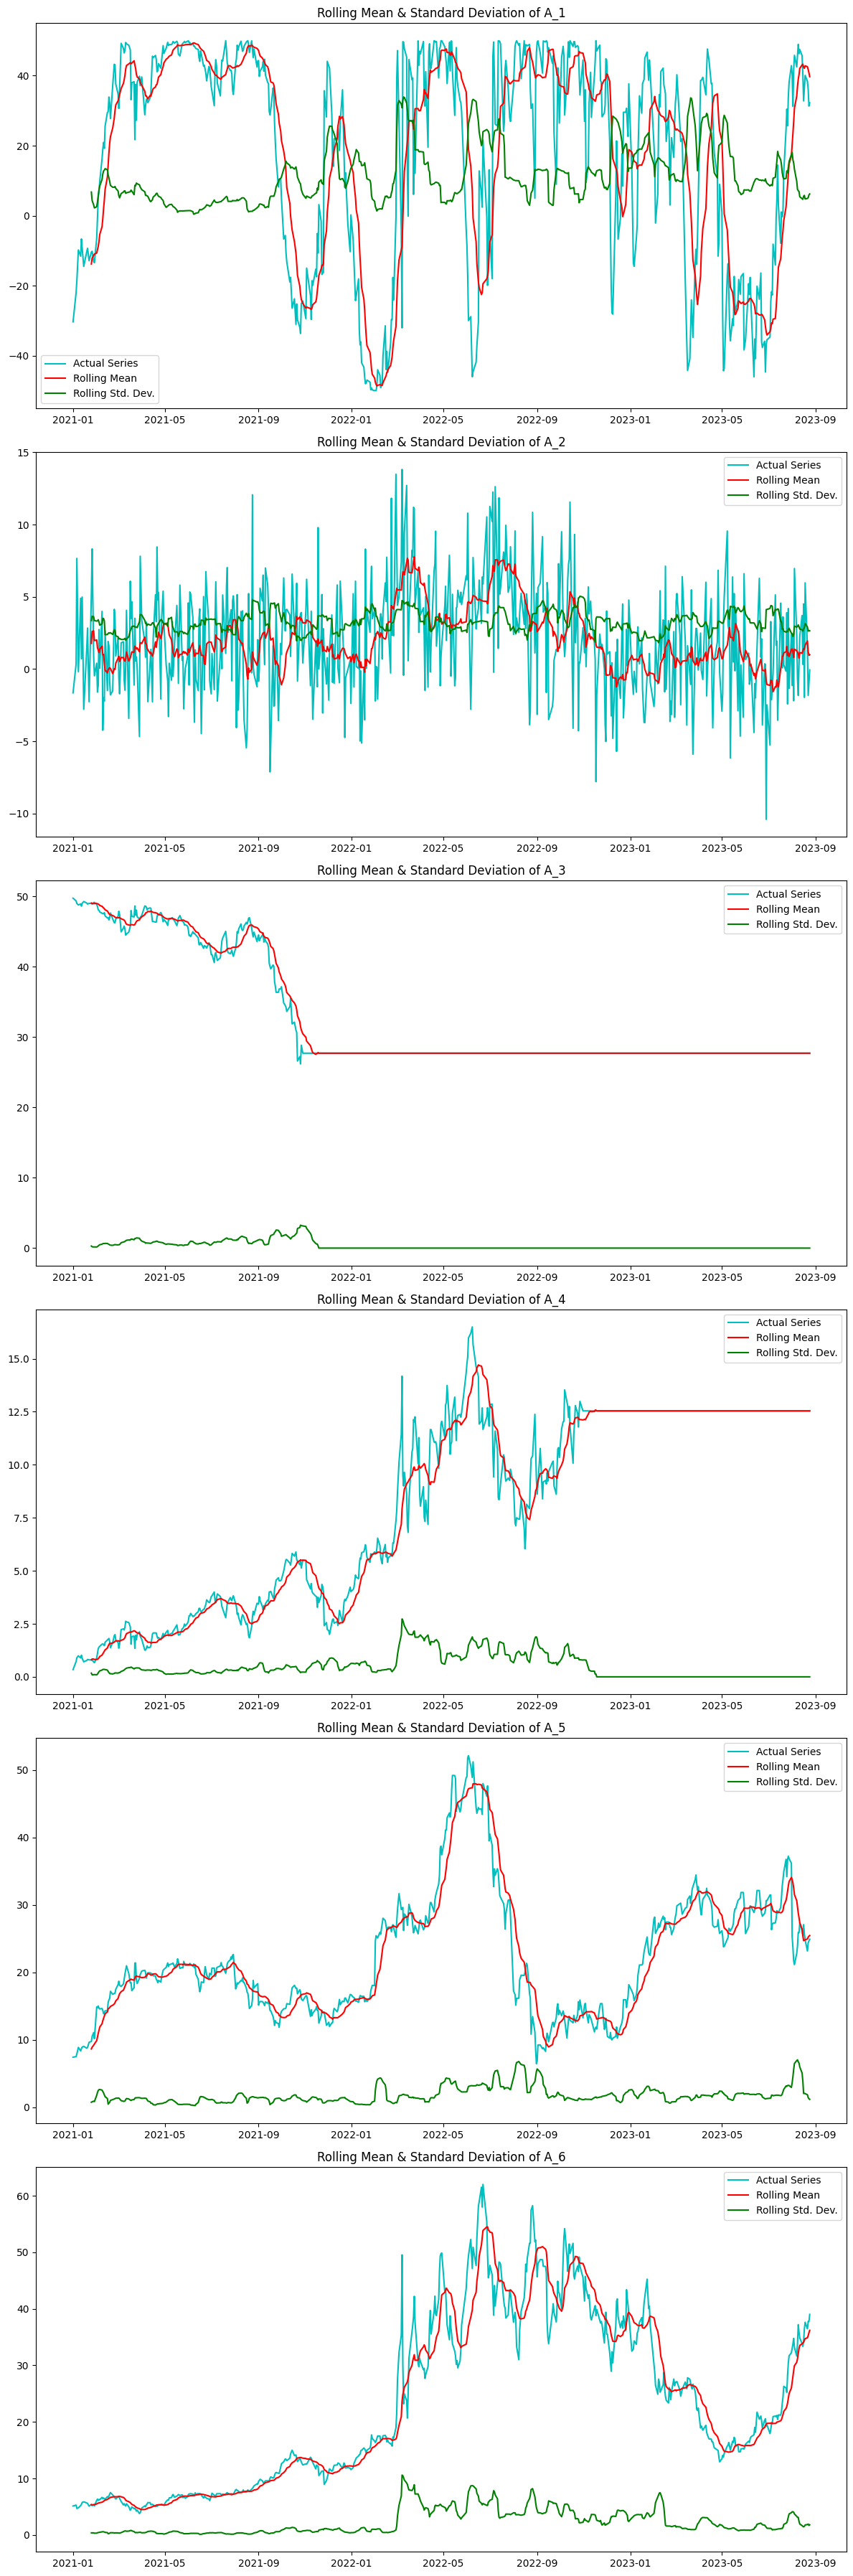

In [12]:
def rolling_plots(df, cols):
    fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(12, 6 * len(cols)))

    for i, col in enumerate(cols):
            rolmean = df[col].rolling(window=12).mean()
            rolstd = df[col].rolling(window=12).std()
            
            axes[i].plot(df[col], color='c', label='Actual Series')
            axes[i].plot(rolmean, color='red', label='Rolling Mean')
            axes[i].plot(rolstd, color='green', label='Rolling Std. Dev.')
            axes[i].set_title(f'Rolling Mean & Standard Deviation of {col}')
            axes[i].legend()

    plt.tight_layout()
    plt.show()

rolling_plots(df,cols)

In [5]:
def year_split(df):
    yrs = df.index.year.unique()
    dfs = []

    for yr in yrs:
        temp = df[df.index.year == yr]
        end_date = f"{list(temp.index.year)[0]}-09-30"
        filtered_yr = temp[temp.index <= end_date]
        dfs.append(filtered_yr)

    return dfs

yrs = year_split(df)

def rolling_cointegration_analysis(yr, col1, col2, window_size=30, significance_threshold=0.05):

    cointegration_results = pd.DataFrame(columns=['Start Date', 'End Date', 'P-value'])

    p_values = []
    start_dates = []
    end_dates = []

    for i in range(len(yr) - window_size + 1):
        window_data = yr.iloc[i:i+window_size] 
        result = coint(window_data[col1], window_data[col2])

        cointegration_results = cointegration_results.append({
            'Start Date': window_data.index[0],
            'End Date': window_data.index[-1],
            'P-value': result[1]
        }, ignore_index=True)

        p_values.append(result[1])
        start_dates.append(window_data.index[0])
        end_dates.append(window_data.index[-1])

    significant_results = cointegration_results[cointegration_results['P-value'] < significance_threshold]

    plt.figure(figsize=(12, 6))
    plt.plot(start_dates, p_values, label='P-value', color='blue')
    plt.axhline(significance_threshold, color='red', linestyle='--', label=f'Significance Threshold ({significance_threshold})')
    plt.title(f'Rolling Cointegration Analysis ({col1} vs {col2})')
    plt.xlabel('Time')
    plt.ylabel('P-value')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    # print("Significant Cointegration Results:")
    # print(significant_results)

def relationship_test(df,var1,var2):
    print(f"Covariance between {var1} and {var2}",np.cov(df[var2],df[var2]))
    pearsoncorr, _ = pearsonr(df[var1], df[var2])
    print(f"Pearson corelation: {round(pearsoncorr,3)}")
    spearmancorr, _ = spearmanr(df[var1], df[var2])
    print(f"Spearman corelation: {round(spearmancorr,3)}\n")

def adf_test(df,cols):
    for col in cols:

        sig_level = 0.05

        adf = adfuller(df[col].values,autolag='AIC')
        p_val = adf[1]

        if p_val <= sig_level:
            print(f"\npvalue = {p_val}, null hypothesis rejected")
            print(f"{col} is stationary")
        else:
            print(f"\npvalue = {p_val}, null hypothesis not rejected")
            print(f"{col} is non-stationary") 


def grangers_matrix(data, variables, test='ssr_chi2test'):    
    maxlag=10
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for col in df.columns:
        for row in df.index:
            test_result = grangercausalitytests(data[[row, col]].pct_change().dropna(), maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[row, col] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    display(df)
    return df


NameError: name 'df' is not defined




For year 2021
 ----------------------------------------
Covariance between A_1 and A_2 [[10.45812275 10.45812275]
 [10.45812275 10.45812275]]
Pearson corelation: 0.04
Spearman corelation: 0.037



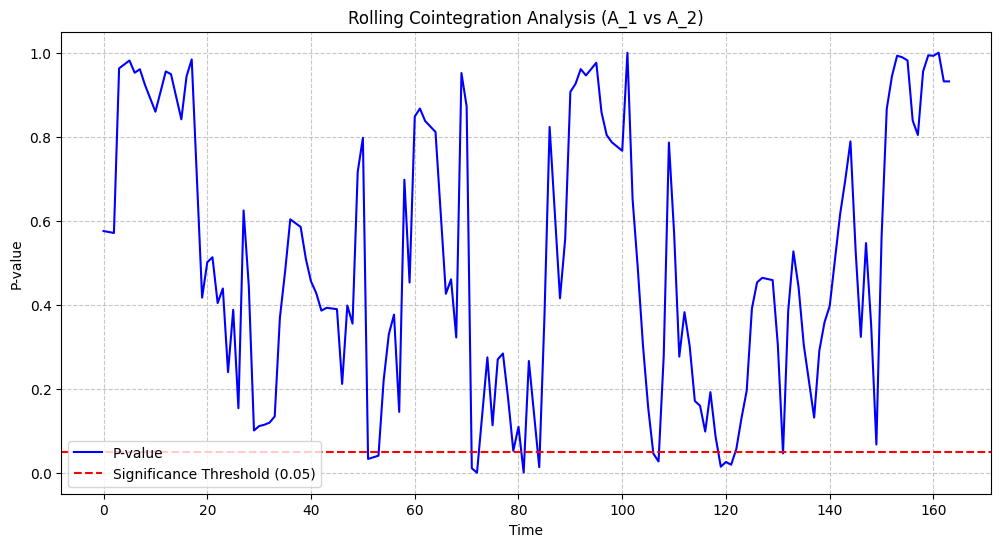

Covariance between A_1 and A_3 [[7.94642651 7.94642651]
 [7.94642651 7.94642651]]
Pearson corelation: -0.293
Spearman corelation: -0.295



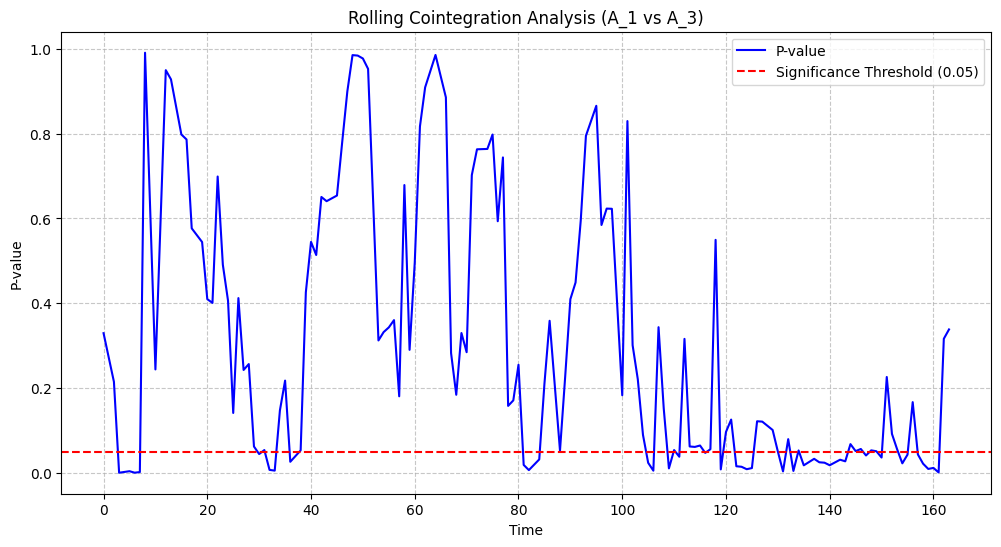

Covariance between A_4 and A_5 [[13.2811421 13.2811421]
 [13.2811421 13.2811421]]
Pearson corelation: 0.333
Spearman corelation: 0.26



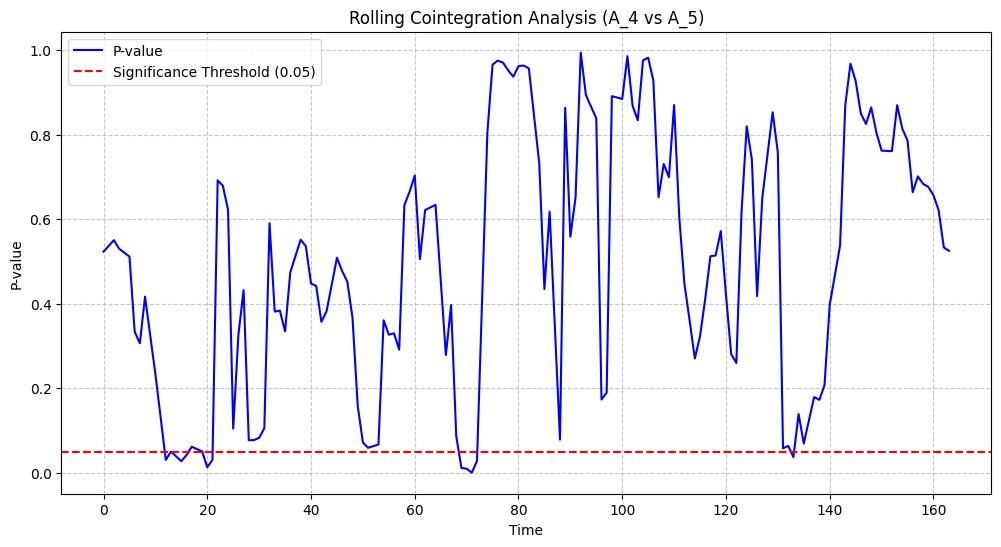

Covariance between A_4 and A_6 [[2.50273458 2.50273458]
 [2.50273458 2.50273458]]
Pearson corelation: 0.734
Spearman corelation: 0.719



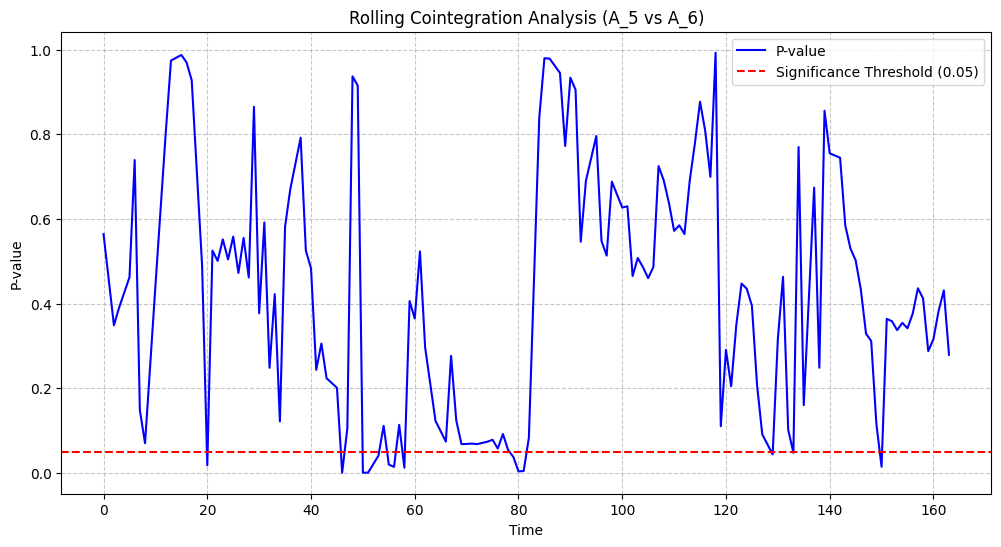




For year 2022
 ----------------------------------------
Covariance between A_1 and A_2 [[15.28991398 15.28991398]
 [15.28991398 15.28991398]]
Pearson corelation: 0.104
Spearman corelation: 0.051



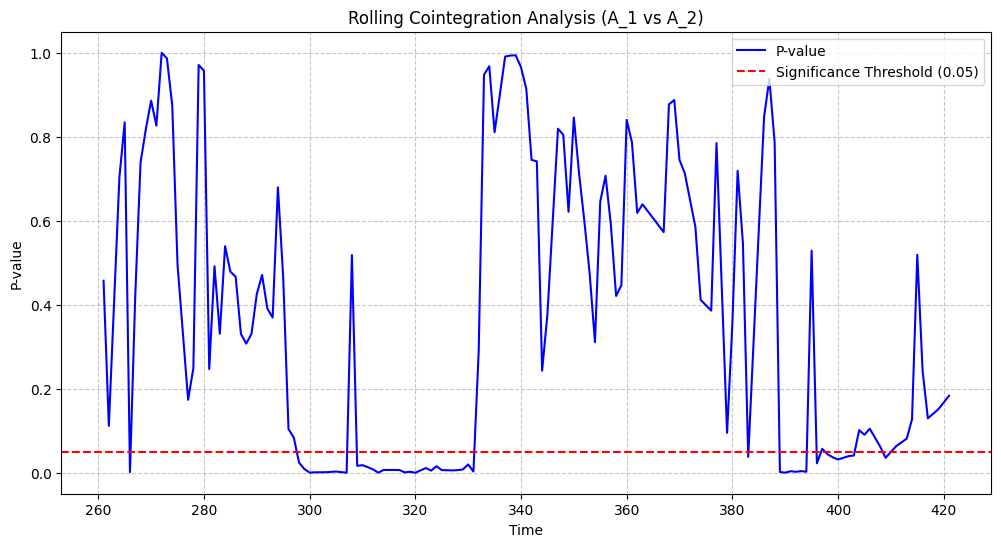

Covariance between A_1 and A_3 [[1.2697354e-29 1.2697354e-29]
 [1.2697354e-29 1.2697354e-29]]
Pearson corelation: nan
Spearman corelation: nan



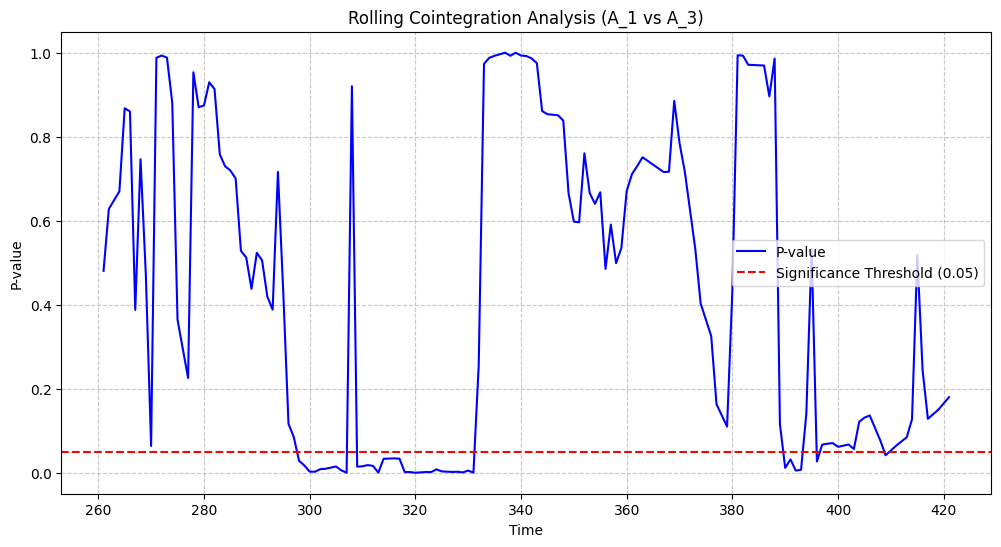

Covariance between A_4 and A_5 [[139.38701715 139.38701715]
 [139.38701715 139.38701715]]
Pearson corelation: 0.653
Spearman corelation: 0.638



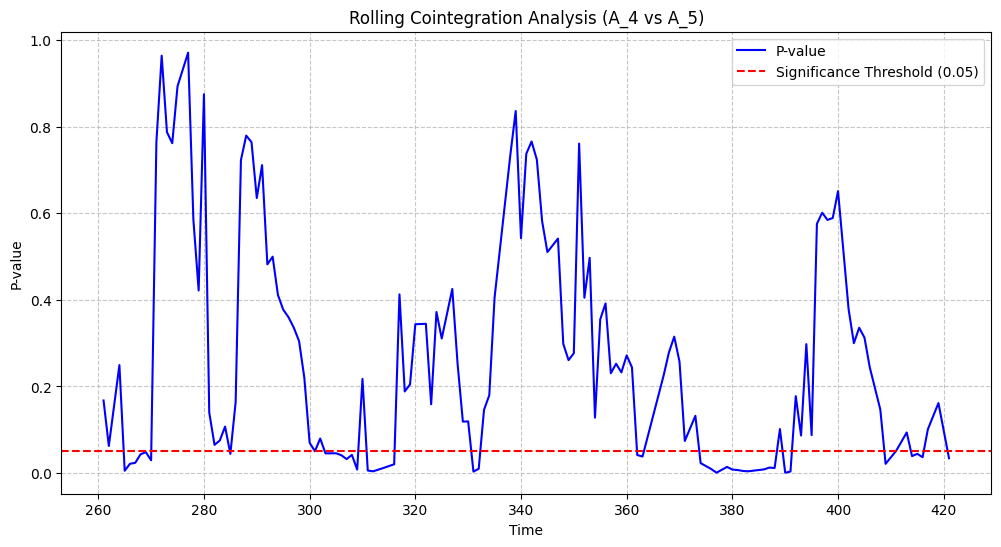

Covariance between A_4 and A_6 [[171.86559401 171.86559401]
 [171.86559401 171.86559401]]
Pearson corelation: 0.739
Spearman corelation: 0.686



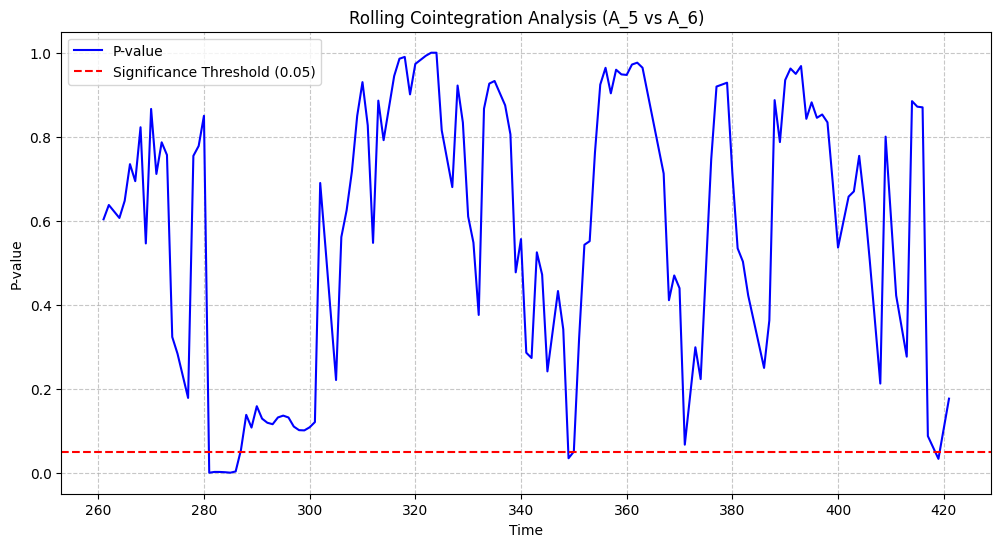




For year 2023
 ----------------------------------------
Covariance between A_1 and A_2 [[10.21825868 10.21825868]
 [10.21825868 10.21825868]]
Pearson corelation: 0.097
Spearman corelation: 0.079



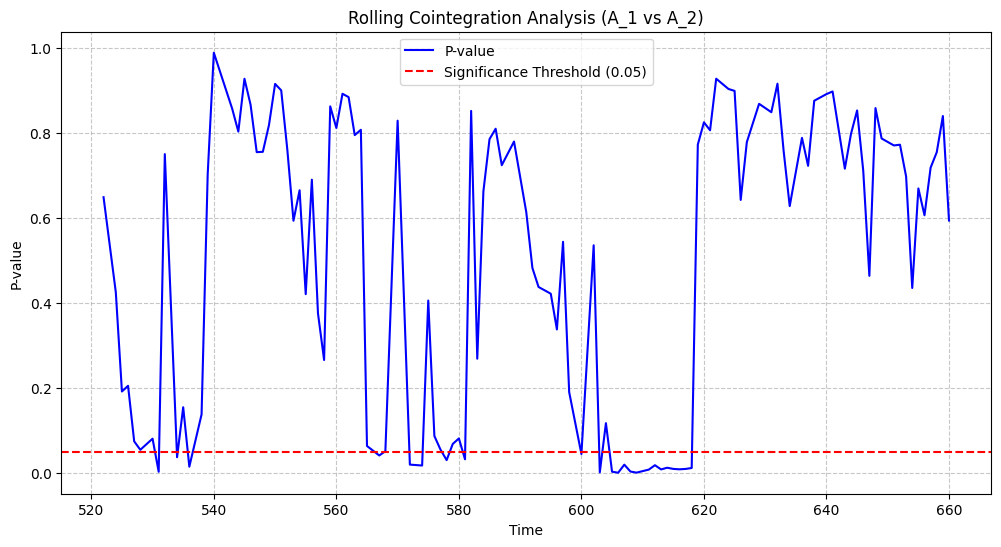

Covariance between A_1 and A_3 [[1.27094257e-29 1.27094257e-29]
 [1.27094257e-29 1.27094257e-29]]
Pearson corelation: nan
Spearman corelation: nan



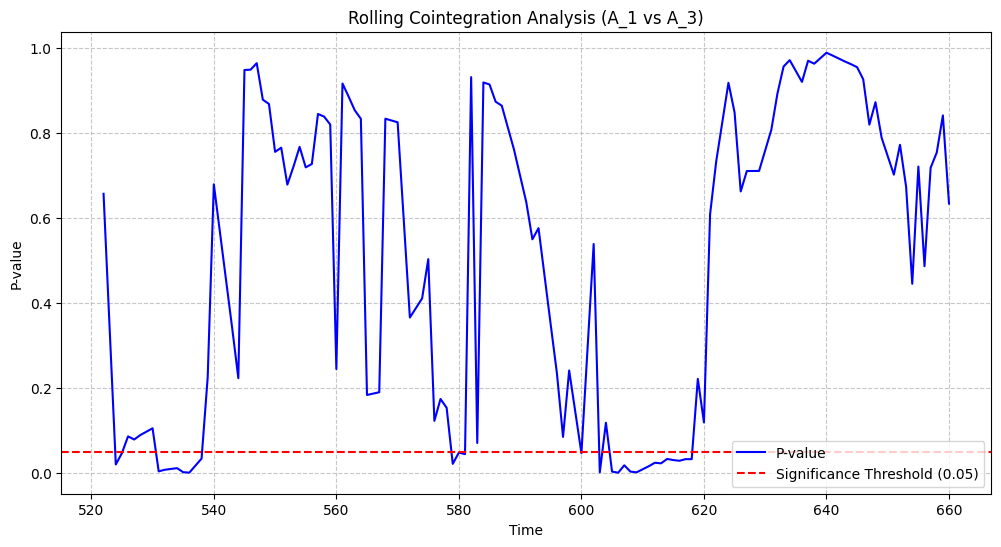

Covariance between A_4 and A_5 [[16.26949892 16.26949892]
 [16.26949892 16.26949892]]
Pearson corelation: nan
Spearman corelation: nan



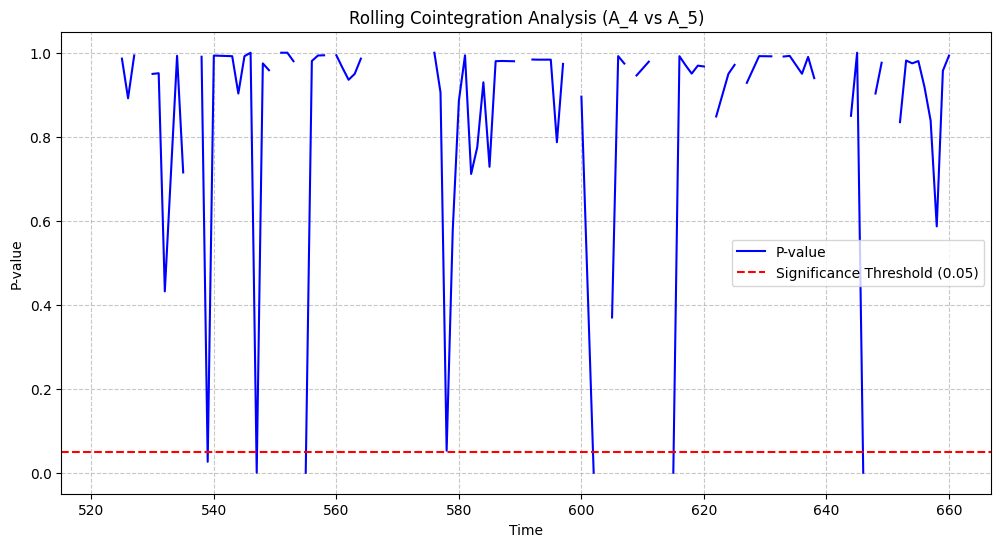

Covariance between A_4 and A_6 [[60.6033732 60.6033732]
 [60.6033732 60.6033732]]
Pearson corelation: nan
Spearman corelation: nan



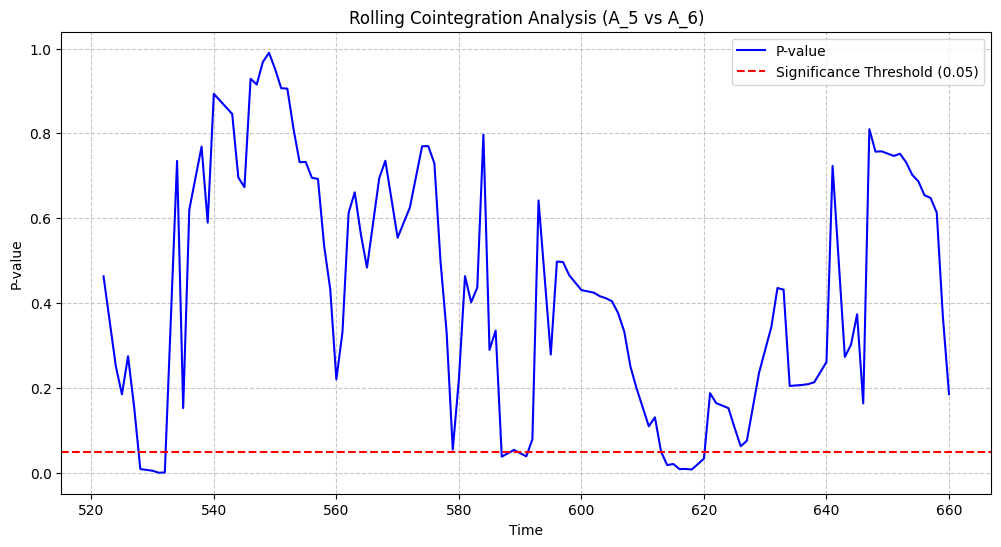

In [7]:
for yr in yrs:
    print(f"\n\n\nFor year {list(yr['Dates'].dt.year)[0]}\n","--"*20)
    relationship_test(yr,"A_1","A_2")
    rolling_cointegration_analysis(yr, col1='A_1', col2='A_2', window_size=30, significance_threshold=0.05)

    relationship_test(yr,"A_1","A_3")
    rolling_cointegration_analysis(yr, col1='A_1', col2='A_3', window_size=30, significance_threshold=0.05)

    relationship_test(yr,"A_4","A_5")
    rolling_cointegration_analysis(yr, col1='A_4', col2='A_5', window_size=30, significance_threshold=0.05)

    relationship_test(yr,"A_4","A_6")
    rolling_cointegration_analysis(yr, col1='A_5', col2='A_6', window_size=30, significance_threshold=0.05)


In [9]:
# for yr in yrs:
#     print(f"\n\n\nFor year {list(yr['Dates'].dt.year)[0]}\n","--"*20)
#     adf_test(yr,cols)
#     grangers_matrix(yr, cols, test='ssr_chi2test')


In [203]:
df = pd.read_csv("Test Data Set.csv",index_col=0)
df['Dates'] = pd.to_datetime(df['Dates'],dayfirst=True)
df = df.dropna(how="any")
cols = ['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6']

df.set_index("Dates",inplace=True)

# diff = df[cols].diff()
# diff.plot(subplots=True,figsize=(12,8))
# plt.show()
df.describe()

,A_1,A_2,A_3,A_4,A_5,A_6
count,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000
mean,18.636228,2.039606,32.956240,7.965943,22.361599,22.937660
std,30.785329,3.724896,8.124455,4.522614,9.103825,15.081127
min,-49.999995,-10.409629,26.183094,0.340000,6.450000,3.780000
25%,-8.076059,-0.595132,27.702392,3.372500,15.525000,8.287500
50%,31.791007,1.882490,27.702392,9.045000,20.630000,17.690000
75%,44.521166,4.505795,42.441053,12.540000,27.915000,36.875000
max,49.999884,13.818425,49.740842,16.500000,52.140000,62.020000


In [161]:
import pandas as pd
from sklearn.decomposition import PCA

# Assuming df is your DataFrame
# Extract A3 and A4 columns
a3_a4 = df[['A_3', 'A_4']]

# Initialize PCA with one component
pca = PCA(n_components=1)

# Fit and transform A3 and A4
pca_result = pca.fit_transform(a3_a4)

# Create a DataFrame with the PCA result and set the column name
df['A3_A4_combined'] = pca_result
df.drop(columns=['A_3', 'A_4'], inplace=True)

# Now, df contains A3 and A4 combined into one component, and A3 and A4 are removed


In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load your time series data into a DataFrame 'df' with Date as the index and multiple columns

# Step 1: Split into train and test
# Choose the number of data points for testing (e.g., n)
n = 50
train_data, test_data = df[:-n], df[-n:]

# Step 2: Check for stationarity and convert
# Perform the Augmented Dickey-Fuller Test (ADF Test) to check for stationarity
def adf_test(df):
    for col in df.columns:
        sig_level = 0.05
        adf = adfuller(df[col].values, autolag='AIC')
        p_val = adf[1]
        if p_val <= sig_level:
            print(f"\np-value = {p_val}, null hypothesis rejected")
            print(f"{col} is stationary")
        else:
            print(f"\np-value = {p_val}, null hypothesis not rejected")
            print(f"{col} is non-stationary")

adf_test(train_data)
train_data_diff = train_data.diff().dropna()
adf_test(train_data_diff)

# Step 3: Scale the data using Min-Max scaling
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data_diff)
test_data_scaled = scaler.transform(test_data)

# Step 4: Select the lag order to minimize AIC
model = VAR(train_data_scaled)
lst = []
for i in range(1, n):  # Adjust the range as needed
    result = model.fit(i)
    lst.append(result.aic)
lag_order_aic = np.argmin(lst) + 1

# Step 5: Train the VAR model with the selected lag order
model_fit = model.fit(lag_order_aic)

# Step 6: Forecast
lag_order = model_fit.k_ar
forecast_input = train_data_scaled[-lag_order:]
fc = model_fit.forecast(y=forecast_input, steps=n)
data_forecast_scaled = pd.DataFrame(fc, index=test_data.index[-n:], columns=df.columns)

# Step 7: Reverse the differencing and scale back to the original using inverse_transform
data_fc_scaled = data_forecast_scaled.copy()
for col in df.columns:
    # Inverse transform to the original scale
    scaled_col = scaler.inverse_transform(data_fc_scaled[col].values.reshape(-1, 1)).flatten()
    data_fc_scaled[col] = scaled_col

# Step 8: Plots (unchanged)
# ...

# Step 9: Metrics (unchanged)
# ...


# Step 8: Plots
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=100, figsize=(10, 8))
for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    data_fc_scaled[col].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    test_data[col][-n:].plot(legend=True, ax=ax)
    ax.set_title(f"{col}: Forecast vs Real")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

# Step 9: Metrics
for col in df.columns:
    mape = np.mean(np.abs(data_fc_scaled[col] - test_data[col][-n:]) / np.abs(test_data[col][-n:]))
    mpe = np.mean((data_fc_scaled[col] - test_data[col][-n:]) / test_data[col][-n:])
    rmse = np.sqrt(np.mean((data_fc_scaled[col] - test_data[col][-n:]) ** 2))
    print(f"For variable: {col}")
    print(f"MAPE = {mape:.4f}\nMPE  = {mpe:.4f}\nRMSE = {rmse:.4f}\n")



p-value = 0.011502504840755452, null hypothesis rejected
A_1 is stationary

p-value = 0.04965175116764283, null hypothesis rejected
A_2 is stationary

p-value = 0.26813092156682217, null hypothesis not rejected
A_5 is non-stationary

p-value = 0.6763813890076983, null hypothesis not rejected
A_6 is non-stationary

p-value = 0.3645927586633383, null hypothesis not rejected
A3_A4_combined is non-stationary

p-value = 1.3393084198051765e-26, null hypothesis rejected
A_1 is stationary

p-value = 5.630586850086804e-11, null hypothesis rejected
A_2 is stationary

p-value = 0.0, null hypothesis rejected
A_5 is stationary

p-value = 1.0202908233229554e-11, null hypothesis rejected
A_6 is stationary

p-value = 0.0, null hypothesis rejected
A3_A4_combined is stationary


ValueError: non-broadcastable output operand with shape (50,1) doesn't match the broadcast shape (50,5)

Selected lag order based on AIC: 2
For variable: A_1
mape = 5.355067385949959
mpe  = 0.030024004974348824
rmse = 53.78889671774671

For variable: A_2
mape = 1.7893570077909606
mpe  = -0.7488834266066943
rmse = 3.7082372239888737

For variable: A_5
mape = 0.19034413243376178
mpe  = 0.17815869394670603
rmse = 6.130167526003993

For variable: A_6
mape = 0.497069874018217
mpe  = 0.4632573261161401
rmse = 10.011039999537804

For variable: A3_A4_combined
mape = 0.3698519344581872
mpe  = 0.3698519344581872
rmse = 2.8708929548341917



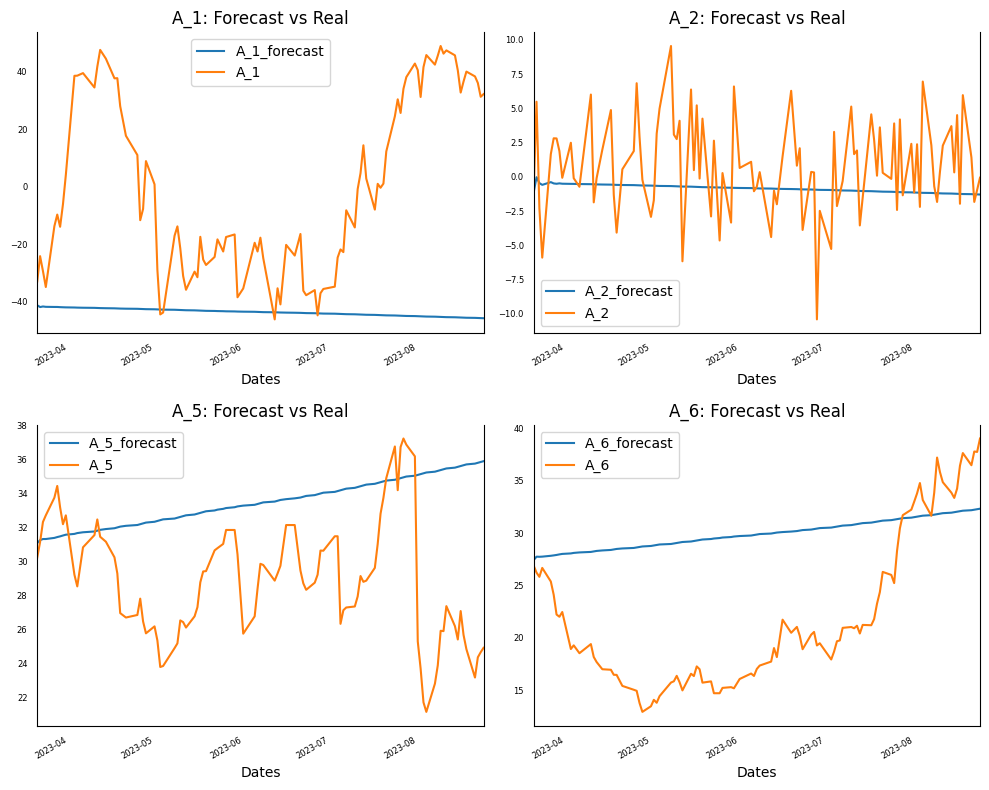

In [188]:
# Example code for selecting the lag order
from statsmodels.tsa.api import VAR

model = VAR(train_data_diff)
results = model.select_order(maxlags=10)  # Adjust maxlags as needed
lag_order_selected = results.selected_orders['aic']
print(f"Selected lag order based on AIC: {lag_order_selected}")
model_fit = model.fit(lag_order_selected)
# Example code for forecasting and evaluation
forecast_input = train_data_diff
fc = model_fit.forecast(y=forecast_input.values, steps=len(test_data))
data_forecast = pd.DataFrame(fc, index=test_data.index, columns=df.columns)

# Calculate evaluation metrics (MAPE, MPE, RMSE) and plot forecasts
# (This part is similar to your existing code)
# Step 10: Plots
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=100, figsize=(10,8))
for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    data_fc[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    test_data[col][-n:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Real")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

# Step 11: Metrics
for i, j in zip(df.columns, data_fc.columns):
    if i in j:
        mape = np.mean(np.abs(data_fc[j] - test_data[i]) / np.abs(test_data[i]))
        mpe = np.mean((data_fc[j] - test_data[i]) / test_data[i])
        rmse = np.mean((data_fc[j] - test_data[i])**2)**0.5
        print(f"For variable: {i}")
        print(f"mape = {mape}\nmpe  = {mpe}\nrmse = {rmse}\n")

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

     


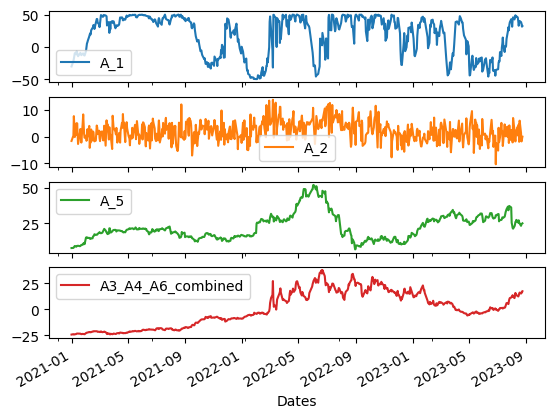

In [227]:
df = pd.read_csv("Test Data Set.csv",index_col=0)
df['Dates'] = pd.to_datetime(df['Dates'],dayfirst=True)
df = df.dropna(how="any")
cols = ['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6']

df.set_index("Dates",inplace=True)

a3_a4 = df[['A_3', 'A_4', 'A_6']]

# Initialize PCA with one component
pca = PCA(n_components=1)

# Fit and transform A3 and A4
pca_result = pca.fit_transform(a3_a4)

# Create a DataFrame with the PCA result and set the column name
df['A3_A4_A6_combined'] = pca_result
df.drop(columns=['A_3', 'A_4', 'A_6'], inplace=True)
df.plot(subplots=True)
plt.show()


In [228]:
cols = ['A_1', 'A_2', 'A_5', 'A3_A4_A6_combined']

In [231]:
yrs = year_split(df)
for yr in yrs:

    gr = grangers_matrix(yr[cols],cols)

,A_1_x,A_2_x,A_5_x,A3_A4_A6_combined_x
A_1_y,1.0000,0.7859,0.0000,0.1327
A_2_y,0.0516,1.0000,0.0360,0.0203
A_5_y,0.7084,0.0750,1.0000,0.2372
A3_A4_A6_combined_y,0.6728,0.1600,0.6168,1.0000


,A_1_x,A_2_x,A_5_x,A3_A4_A6_combined_x
A_1_y,1.0000,0.4596,0.5115,0.0000
A_2_y,0.9696,1.0000,0.9046,0.8166
A_5_y,0.6792,0.1707,1.0000,0.6006
A3_A4_A6_combined_y,0.0000,0.4022,0.3736,1.0000


,A_1_x,A_2_x,A_5_x,A3_A4_A6_combined_x
A_1_y,1.0000,0.7973,0.8869,0.6383
A_2_y,0.2732,1.0000,0.4020,0.4198
A_5_y,0.4898,0.0173,1.0000,0.0065
A3_A4_A6_combined_y,0.9374,0.0000,0.6337,1.0000


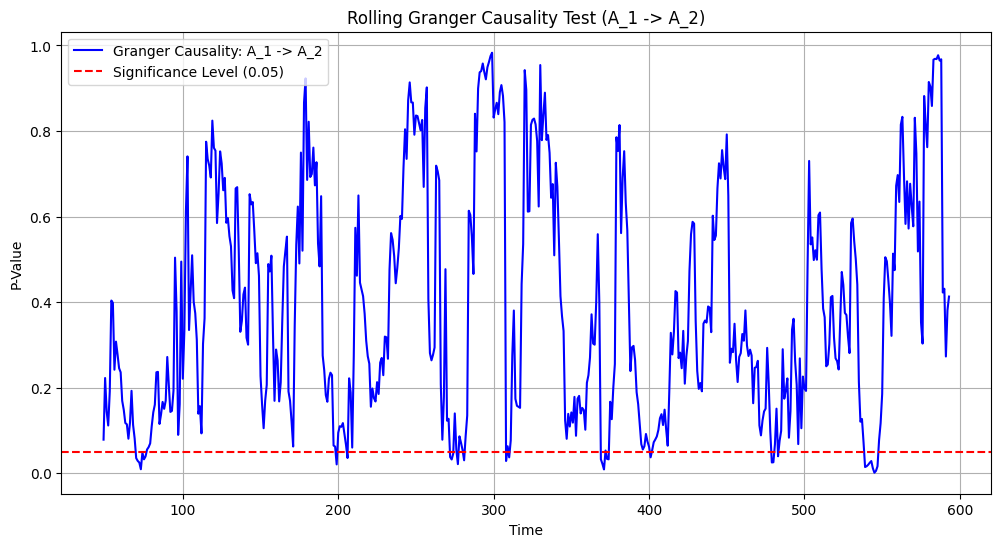

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

def plot_rolling_causality(data, variable1, variable2, max_lag=10, window_size=50):
    """
    Perform a rolling Granger causality test between two variables and plot the p-values.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the time series data.
    - variable1 (str): The name of the first variable.
    - variable2 (str): The name of the second variable.
    - max_lag (int): The maximum lag to consider in the Granger causality test.
    - window_size (int): The size of the rolling window.

    Returns:
    - None (plots the results).
    """
    p_values = []
    n = len(data)

    for i in range(n - window_size + 1):
        window_data = data.iloc[i:i + window_size]
        result = grangercausalitytests(window_data[[variable1, variable2]], max_lag, verbose=False)
        p_value = result[max_lag][0]['ssr_ftest'][1]
        p_values.append(p_value)

    plt.figure(figsize=(12, 6))
    plt.plot(range(window_size - 1, n), p_values, label=f'Granger Causality: {variable1} -> {variable2}', color='blue')
    plt.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)')
    plt.xlabel('Time')
    plt.ylabel('P-Value')
    plt.title(f'Rolling Granger Causality Test ({variable1} -> {variable2})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming you have a DataFrame 'df' with columns 'Variable1' and 'Variable2'


2021-01-01 00:00:00


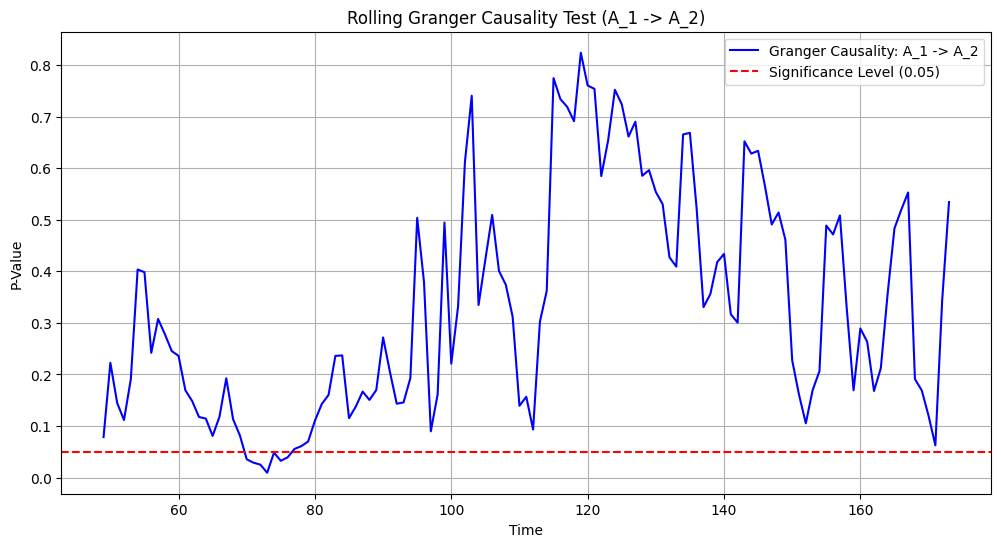

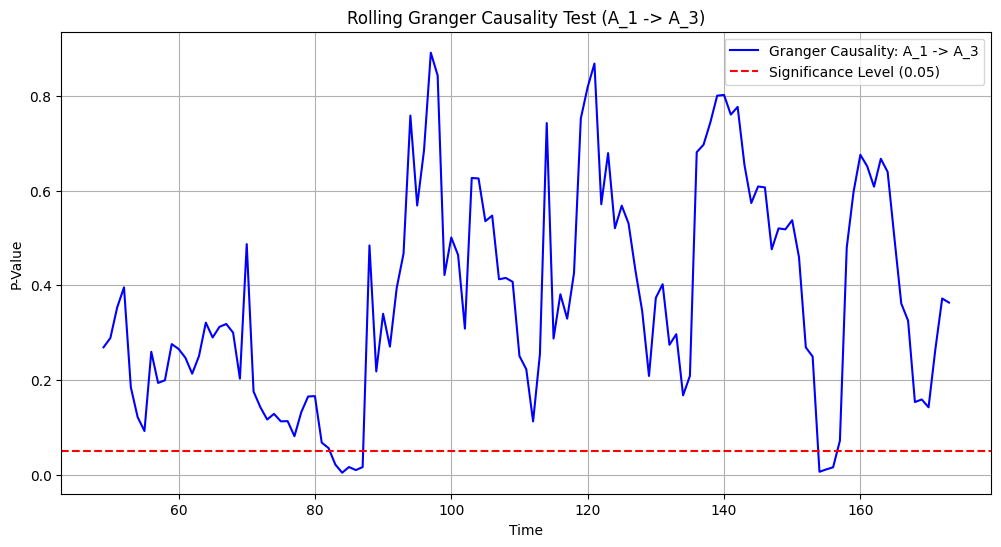

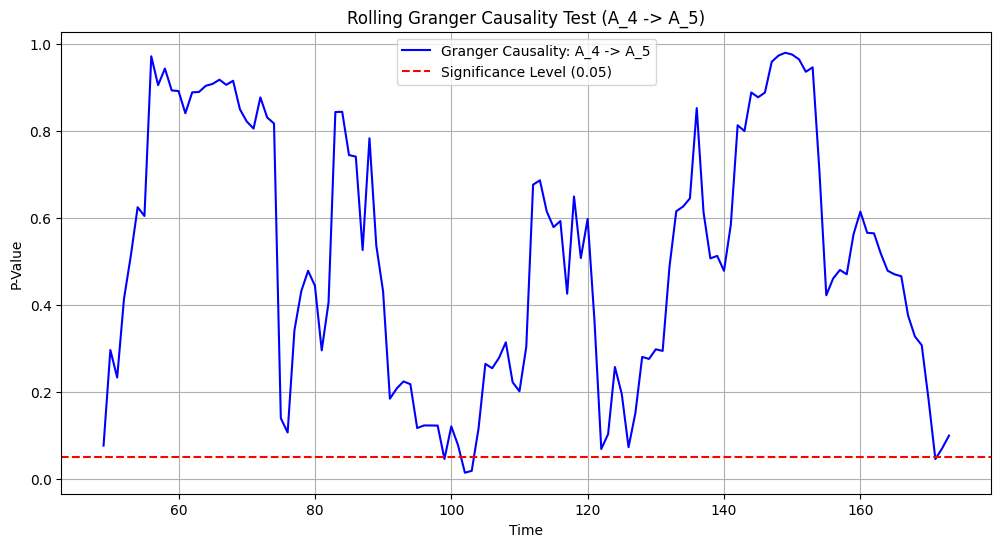

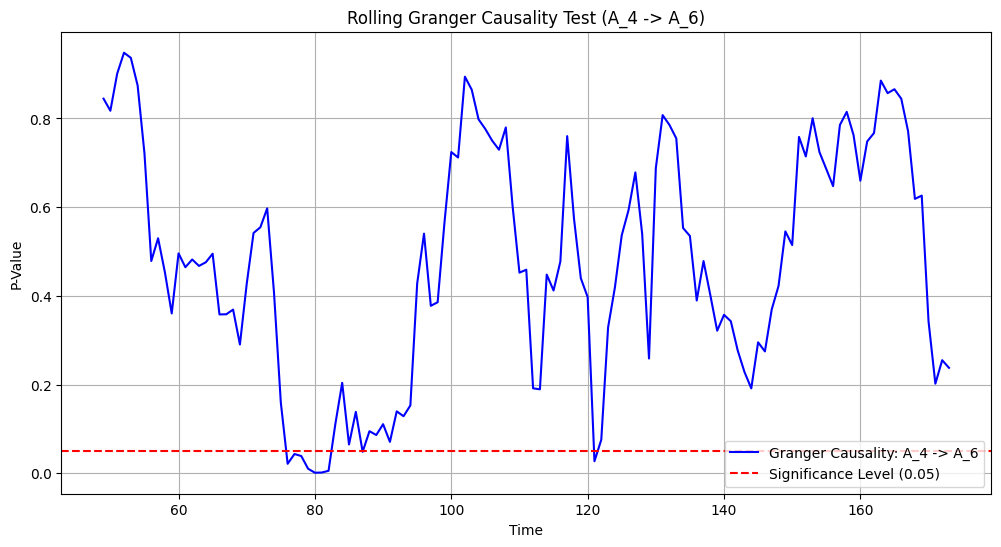

2022-01-03 00:00:00


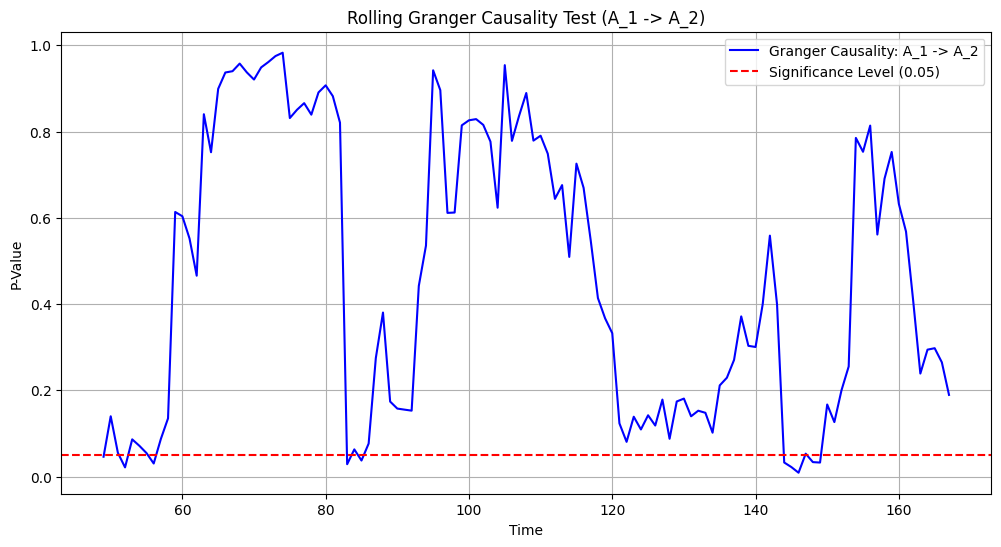

2023-01-03 00:00:00


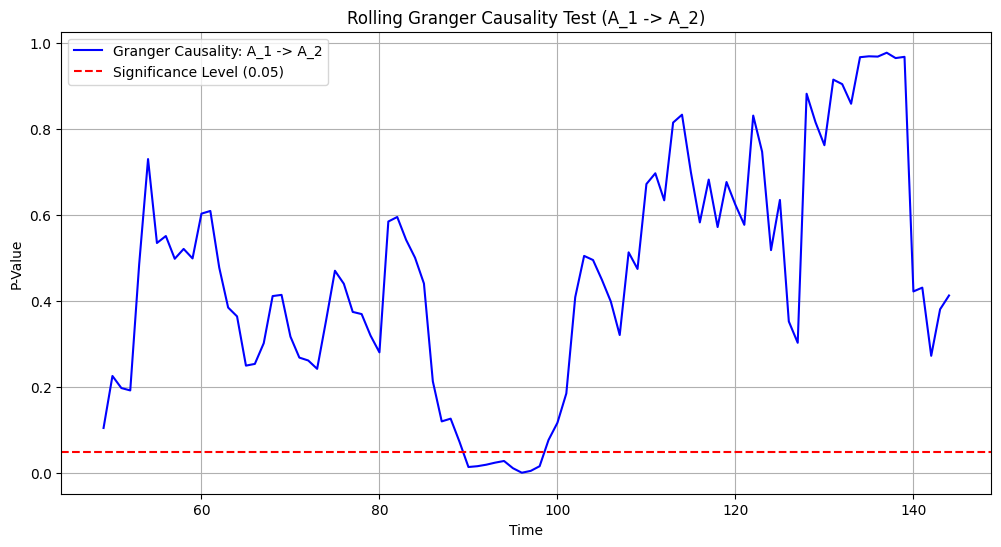

In [240]:
df = get_data()
yrs = year_split(df)
for yr in yrs:
    try:
        print(yr.index[0])
        plot_rolling_causality(yr, 'A_1', 'A_2', max_lag=10, window_size=50)
        plot_rolling_causality(yr, 'A_1', 'A_3', max_lag=10, window_size=50)
        plot_rolling_causality(yr, 'A_4', 'A_5', max_lag=10, window_size=50)
        plot_rolling_causality(yr, 'A_4', 'A_6', max_lag=10, window_size=50)

    except:
        pass



In [248]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as ts

A = df["A_1"]
B = df["A_2"]

df = pd.concat([A, B], axis=1)
df
df['ii'] = range(len(df))

df['ii'].rolling(100).apply(lambda ii: ts.coint(df.loc[ii, 'A'], df.loc[ii, 'B'])[0])

KeyError: 'A'

In [276]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as ts
df = get_data()
# Assuming you have a DataFrame 'df' with columns 'A_1' and 'A_2'
A = pd.DataFrame(df["A_1"].tolist(), columns=['A'])
B = pd.DataFrame(df["A_2"].tolist(), columns=['B'])


df = pd.concat([A, B], axis=1)

display(df)
df['ii'] = range(len(df))

df["c"] = df['ii'].rolling(100).apply(lambda ii: ts.coint(df.loc[ii, 'A'], df.loc[ii, 'B'])[0])

,A,B
0,-30.350131,-1.649292
1,-22.041486,0.343078
2,-18.551989,7.660540
3,-9.791329,-0.185945
4,-11.579214,4.902499
...,...,...
589,40.080057,5.965446
590,38.404592,1.417818
591,36.125267,-1.829972
592,31.319452,-0.950582


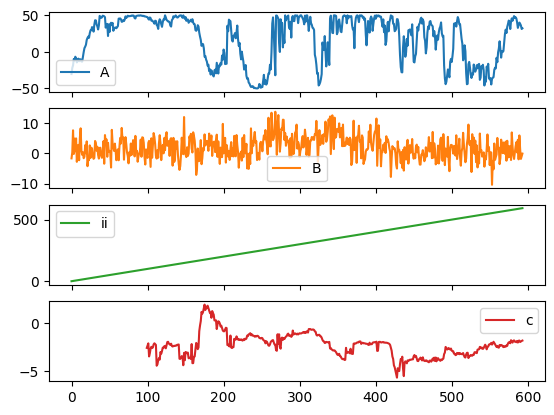

In [277]:
df.plot(subplots=True)
plt.show()

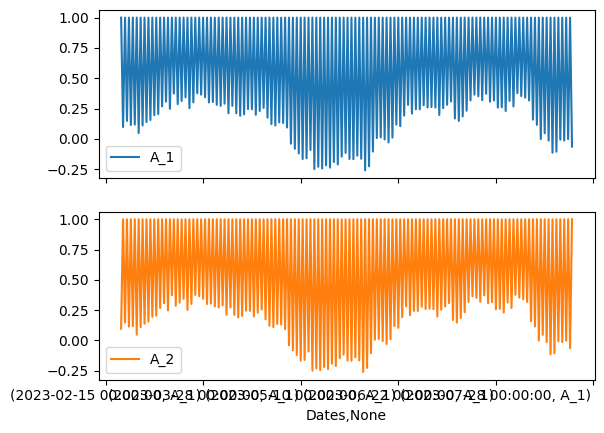

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = get_data()

# Step 1: Filter the data for the specified date range
start_date = '2023-01-01'
end_date = '2023-09-30'
filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

# Step 2: Analyze relationships (e.g., correlations)
correlation_matrix = filtered_df[['A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6']].corr()

# Step 3: Detect periods of significant change (e.g., rolling correlations)
rolling_window = 30  # Adjust the window size as needed
rolling_correlations = filtered_df[['A_1', 'A_2']].rolling(window=rolling_window).corr()
# Plot rolling correlations to visualize changes

# Step 4: Deduce insights from the data and visualizations

# Repeat the above steps for relationships between A_4, A_5, and A_6 as well.

# Visualize results and insights
# You can use matplotlib or other libraries to create plots and visualizations.
rolling_correlations.plot(subplots=True)
plt.show()

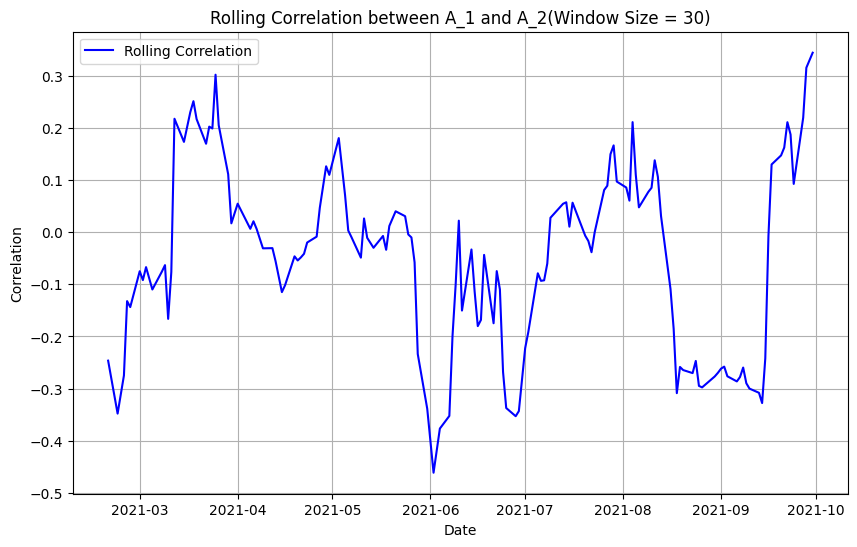

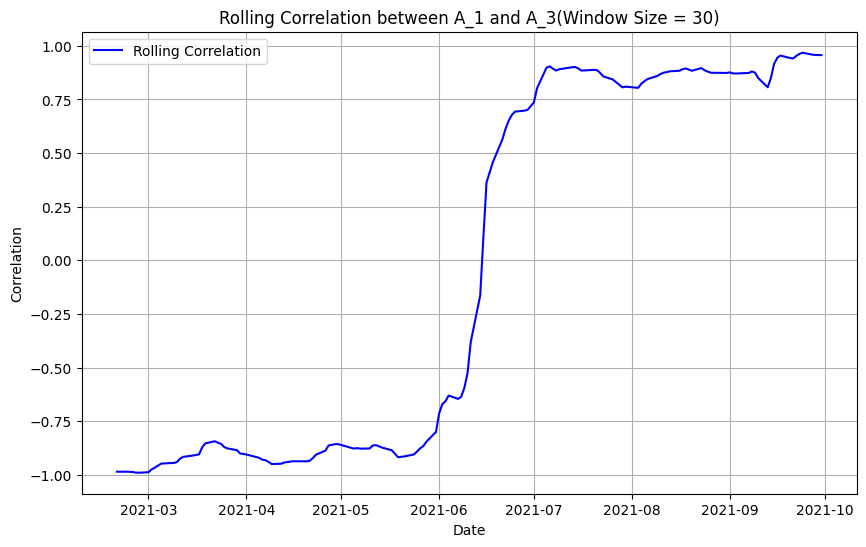

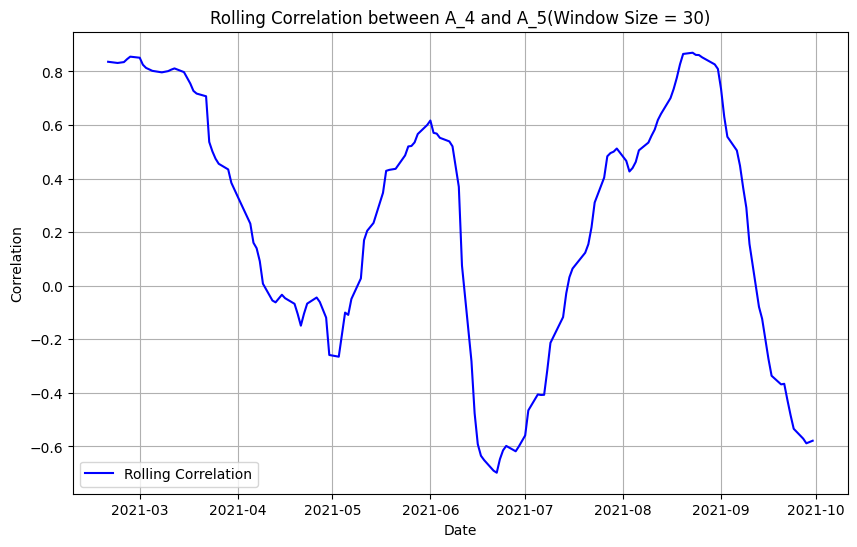

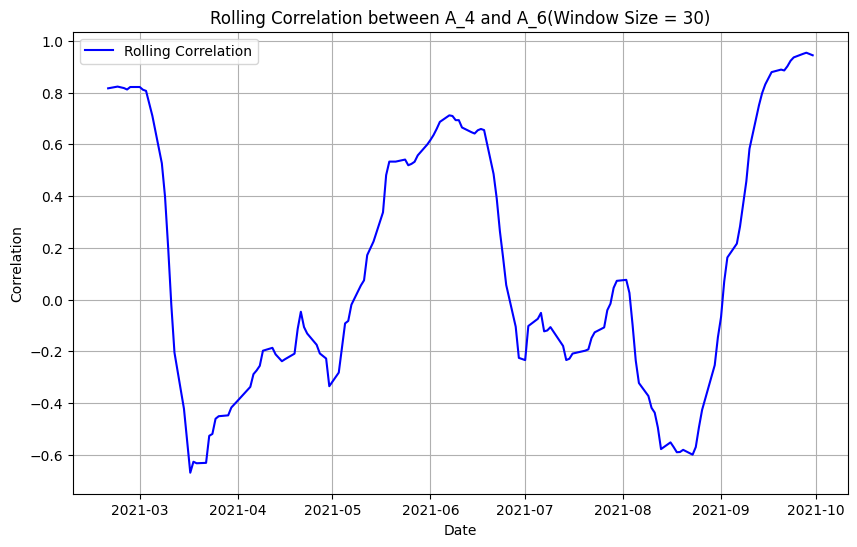

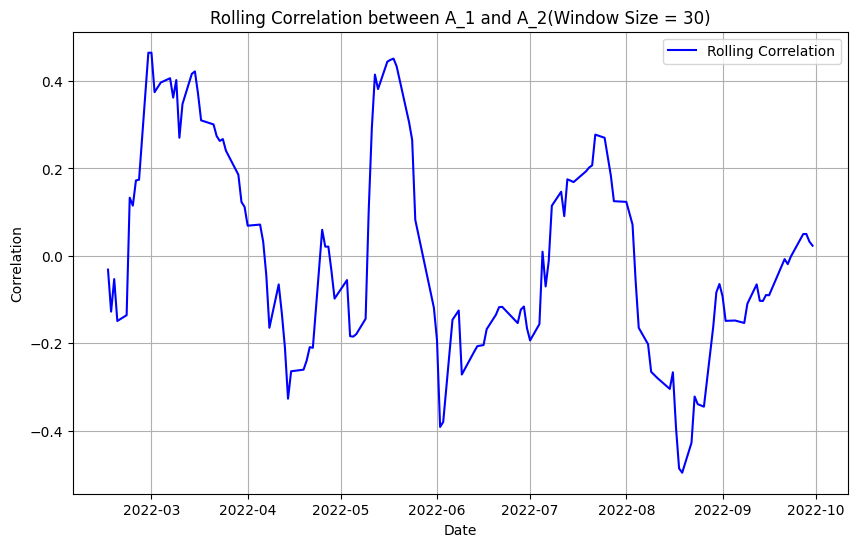

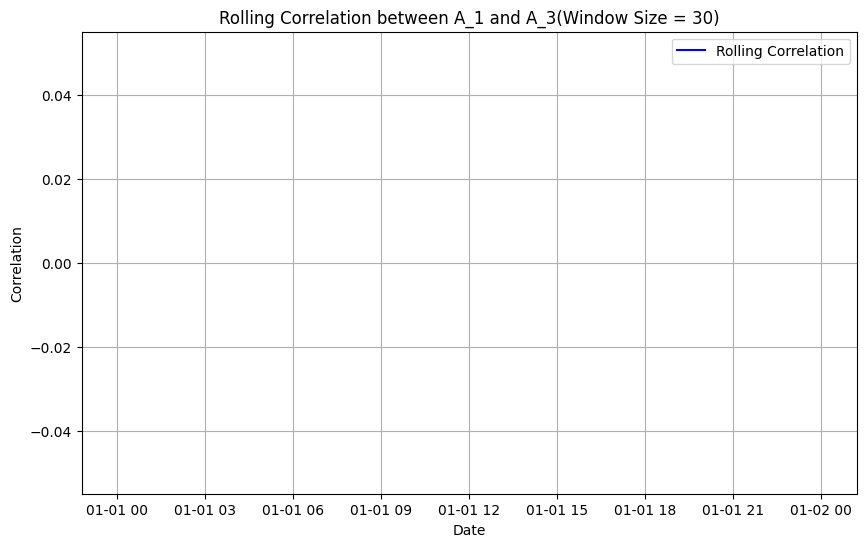

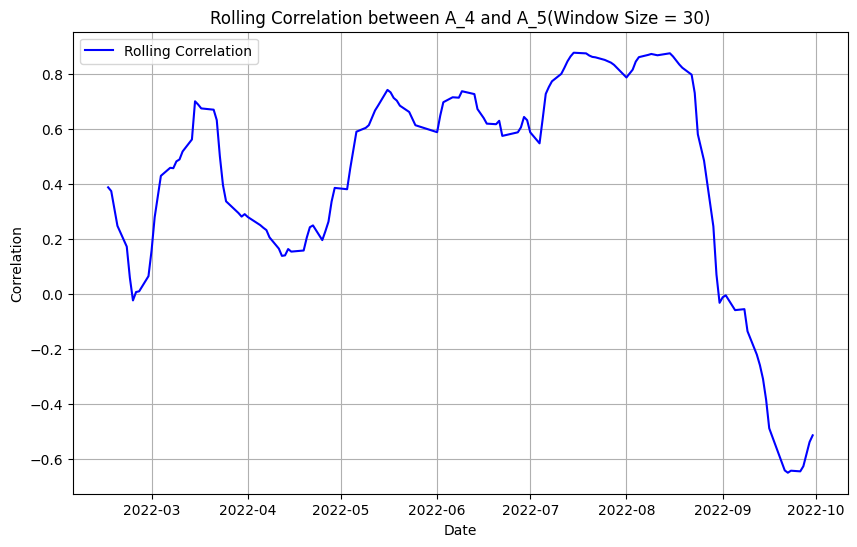

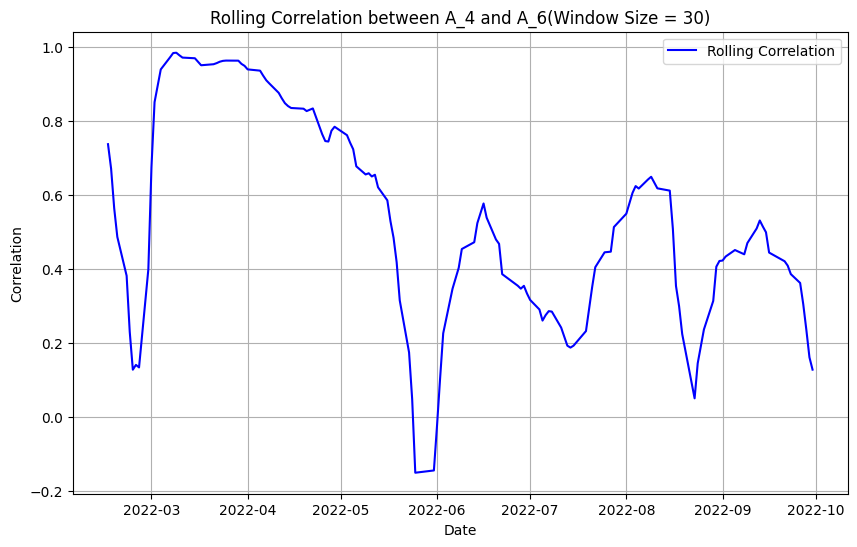

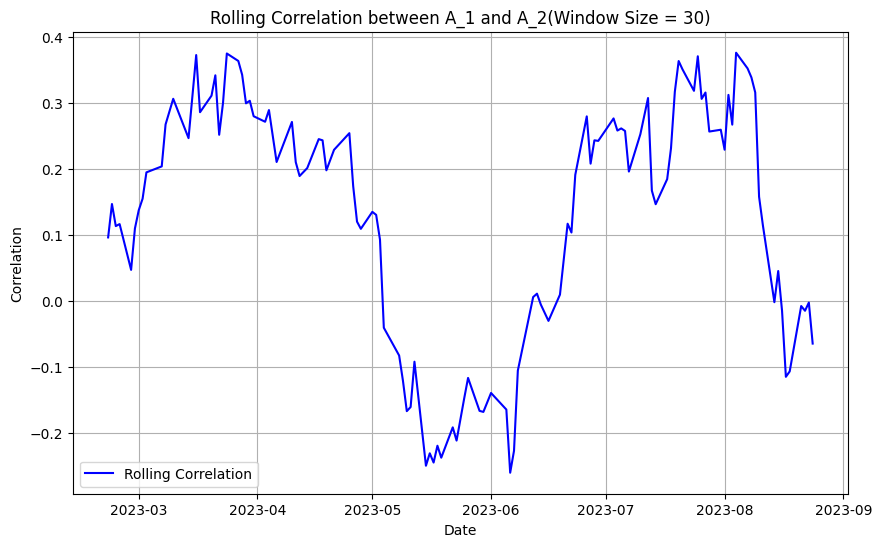

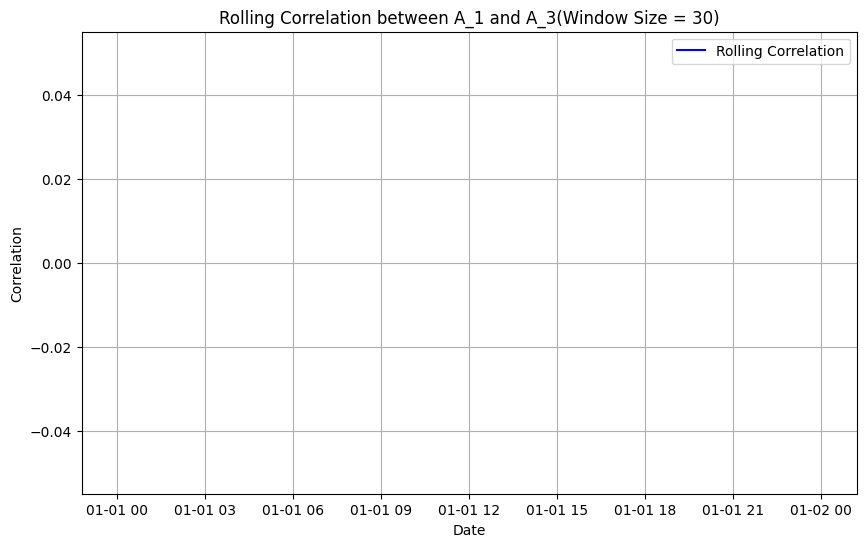

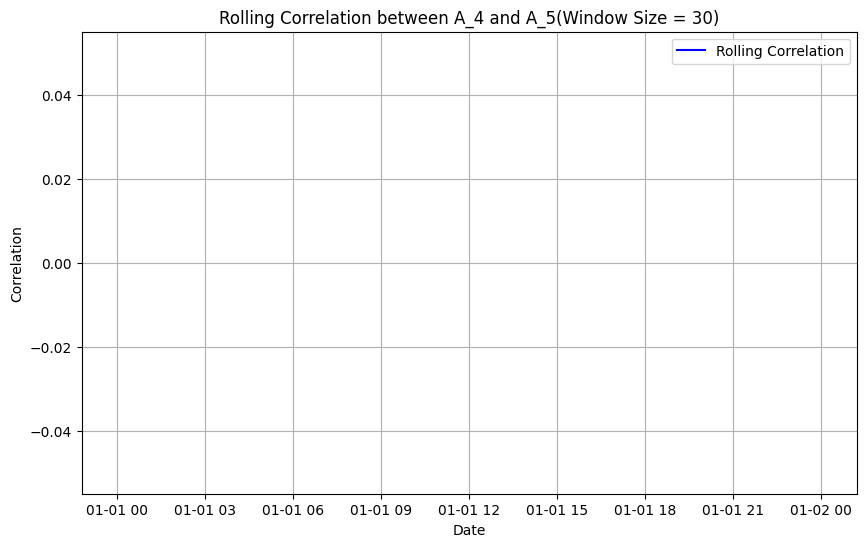

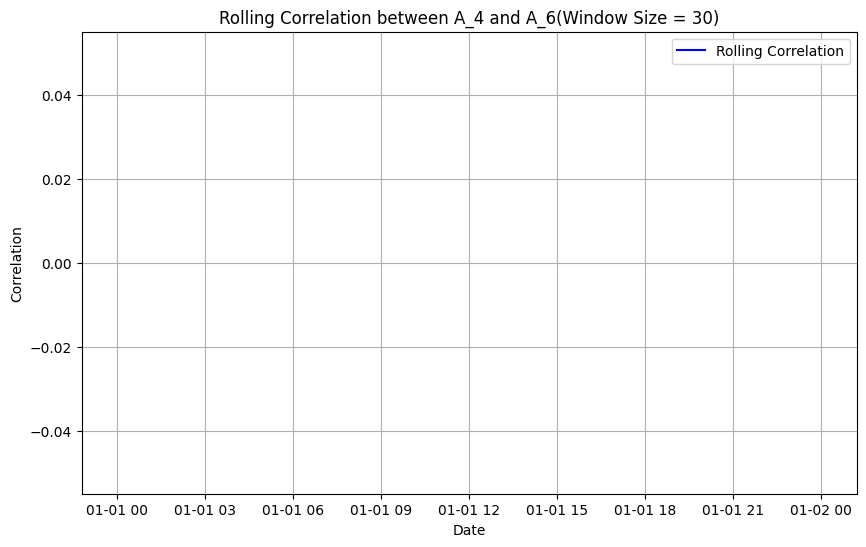

In [290]:
df = get_data()

def rolling_correlation(df,var1='A_1',var2='A_2'):
    rolling_window = 30  # Define your desired rolling window size

    # Calculate the rolling correlation
    rolling_corr = df[var1].rolling(window=rolling_window).corr(df[var2])

    # Plot the rolling correlation
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_corr, label='Rolling Correlation', color='blue')
    plt.title(f'Rolling Correlation between {var1} and {var2}(Window Size = {rolling_window})')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True)
yrs = year_split(df)
for yr in yrs:
    rolling_correlation(yr,'A_1','A_2')
    rolling_correlation(yr,'A_1','A_3')
    rolling_correlation(yr,'A_4','A_5')
    rolling_correlation(yr,'A_4','A_6')
